### Table of Contents
1. [Description](#Desc)
2. [Daily close](#daily)
3. [5 minute data](#5min)

The write up on an introduction to time series data: https://dspyt.com/2021/06/06/time-series-data-an-easy-introduction/

<a id='desc'></a>
# Description
The data: 5 minute Nifty50 price data from 2015-01-09 to 2021-03-25

Trading takes place 9:15 to 15:25 (at least in the given data)

## Importing Libraries

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AR

!pip install arch >/dev/null
from arch.univariate import ARX,  ARCH, GARCH

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)

## Importing and cleaning data

In [2]:
def parser(s):
    return datetime.strptime(s[:19], '%Y-%m-%d %H:%M:%S')

In [3]:
df = pd.read_csv("/kaggle/input/6-year-nifty50-historical-data-of-5-30-min-candle/5min_N50_10yr.csv", usecols = ['date','close'], parse_dates=['date'], date_parser=parser, index_col='date')

In [4]:
df.head(2)

,close
date,
2015-01-09 09:15:00,8301.2
2015-01-09 09:20:00,8301.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114830 entries, 2015-01-09 09:15:00 to 2021-03-25 15:25:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   close   114830 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB


### Ideas to explore

In [6]:
def realized_volatility(series):
    series = np.log(series).diff()
    return np.sqrt(np.sum(series**2))
df.groupby(df.index.date).agg(realized_volatility)

,close
2015-01-09,0.010139
2015-01-12,0.006394
2015-01-13,0.006284
2015-01-14,0.007435
2015-01-15,0.007538
...,...
2021-03-19,0.012456
2021-03-22,0.008741
2021-03-23,0.010783
2021-03-24,0.009118


In [7]:
def realized_quarticity(series):
    series = np.log(series).diff()
    return np.sum(series**4)*series.shape[0]/3
df.groupby(df.index.date).agg(realized_quarticity)

,close
2015-01-09,3.618181e-08
2015-01-12,2.467419e-09
2015-01-13,3.661863e-09
2015-01-14,5.108266e-09
2015-01-15,8.741821e-09
...,...
2021-03-19,2.818765e-08
2021-03-22,4.528229e-09
2021-03-23,2.609275e-08
2021-03-24,1.800327e-08


In [8]:
def realized_quadpower_quarticity(series):
    series = np.log(series).diff()
    series = abs(series.rolling(window=4).apply(np.product, raw=True))
    return (np.sum(series) * series.shape[0] * (np.pi**2))/4
df.groupby(df.index.date).agg(realized_quadpower_quarticity)

,close
2015-01-09,6.535995e-09
2015-01-12,1.467300e-09
2015-01-13,1.087331e-09
2015-01-14,2.291618e-09
2015-01-15,2.352199e-09
...,...
2021-03-19,1.126279e-08
2021-03-22,7.136973e-09
2021-03-23,1.314294e-08
2021-03-24,7.835740e-09


In [9]:
from scipy.special import gamma

In [10]:
def realized_tripower_quarticity(series):
    series = np.log(series).diff() ** (4/3)
    series = abs(series).rolling(window=3).apply(np.prod, raw=True)
    return series.shape[0]*0.25*((gamma(1/2)**3)/(gamma(7/6)**3))*np.sum(series)
df.groupby(df.index.date).agg(realized_quadpower_quarticity)

,close
2015-01-09,6.535995e-09
2015-01-12,1.467300e-09
2015-01-13,1.087331e-09
2015-01-14,2.291618e-09
2015-01-15,2.352199e-09
...,...
2021-03-19,1.126279e-08
2021-03-22,7.136973e-09
2021-03-23,1.314294e-08
2021-03-24,7.835740e-09


In [11]:
def realized_variance(series):
    return np.sum(series**2)
df.groupby(df.index.date).agg(realized_variance)

,close
2015-01-09,5.115726e+09
2015-01-12,5.147619e+09
2015-01-13,5.205811e+09
2015-01-14,5.141607e+09
2015-01-15,5.364663e+09
...,...
2021-03-19,1.595384e+10
2021-03-22,1.616414e+10
2021-03-23,1.641804e+10
2021-03-24,1.607068e+10


In [12]:
def bvar(series):
    series = abs(series).rolling(window=2).apply(np.prod, raw=True)
    return np.sum(series)*((2/np.pi)**(-2))
df.groupby(df.index.date).agg(bvar)

,close
2015-01-09,1.245294e+10
2015-01-12,1.253138e+10
2015-01-13,1.267393e+10
2015-01-14,1.251658e+10
2015-01-15,1.306079e+10
...,...
2021-03-19,3.884018e+10
2021-03-22,3.934953e+10
2021-03-23,3.996929e+10
2021-03-24,3.912358e+10


In [13]:
def Jvar(series):
    series = np.log(series).diff()
    series = (realized_variance(series)-bvar(series)).apply(lambda x: 0 if x < 0 else x )
    return series
df.groupby(df.index.date).agg(Jvar)[df.groupby(df.index.date).agg(Jvar).close>0]

,close
2015-01-29,2.989735e-05
2015-03-03,3.465712e-06
2015-03-26,1.650459e-05
2015-08-17,9.118860e-07
2015-09-29,1.867436e-06
2015-11-11,2.094858e-07
2015-11-20,6.850363e-06
2015-12-28,1.096691e-06
2016-03-16,3.313165e-06
2016-05-05,1.056181e-05


In [14]:
def Cvar(series):
    series = np.log(series).diff()
    series = (realized_variance(series)-Jvar(series)).apply(lambda x: 0 if x < 0 else x )
    return series

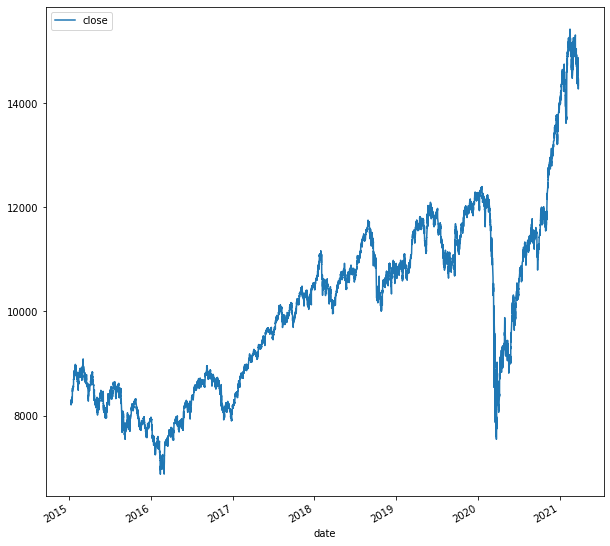

In [15]:
df.plot(figsize=(10,10))
plt.savefig('plot.png')# to save the plot
plt.show()

2 Realized volatility estimators

In [16]:
def realized_1(series):
    series = np.log(series).diff()
    return np.sqrt(np.sum(series**4)/(6*np.sum(series**2)))
df.groupby(df.index.date).agg(realized_1)

,close
2015-01-09,0.001532
2015-01-12,0.000634
2015-01-13,0.000786
2015-01-14,0.000785
2015-01-15,0.001013
...,...
2021-03-19,0.001101
2021-03-22,0.000629
2021-03-23,0.001223
2021-03-24,0.001202


In [17]:
def realized_2(series):
    series = np.log(series).diff()
    return np.sqrt(((np.pi**2)*np.sum(abs(series.rolling(window=4).apply(np.product, raw=True))))/(8*np.sum(series**2)))
df.groupby(df.index.date).agg(realized_2)

,close
2015-01-09,0.000651
2015-01-12,0.000489
2015-01-13,0.000428
2015-01-14,0.000526
2015-01-15,0.000525
...,...
2021-03-19,0.000696
2021-03-22,0.000789
2021-03-23,0.000868
2021-03-24,0.000793


In [18]:
df

,close
date,
2015-01-09 09:15:00,8301.20
2015-01-09 09:20:00,8301.00
2015-01-09 09:25:00,8294.15
2015-01-09 09:30:00,8288.50
2015-01-09 09:35:00,8283.45
...,...
2021-03-25 15:05:00,14319.05
2021-03-25 15:10:00,14299.00
2021-03-25 15:15:00,14299.75


In [19]:
def realized_3(series):
    series = np.log(series).diff()
    numerator = (gamma(1/2)**3)*np.sum((abs(series)**(4/3)).rolling(window=3).apply(np.prod))
    denominator = 8 * (gamma(7/6)**3)*np.sum(series**2)
    return np.sqrt(numerator/denominator)
df.groupby(df.index.date).agg(realized_3)

,close
2015-01-09,0.000603
2015-01-12,0.000500
2015-01-13,0.000479
2015-01-14,0.000547
2015-01-15,0.000646
...,...
2021-03-19,0.000831
2021-03-22,0.000749
2021-03-23,0.000821
2021-03-24,0.000745


<a id='daily'></a>
# Daily close price data

In this section we analyse the daily close price for the stock index

In [20]:
data = df[(df.index.minute==25)&(df.index.hour==15)]
data.head(2)

,close
date,
2015-01-09 15:25:00,8280.25
2015-01-12 15:25:00,8326.55


## Stationarity Analysis

Price data

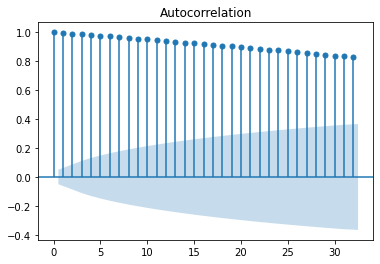

In [21]:
plot_acf(data['close'])
plt.savefig('acf.png')
plt.show()

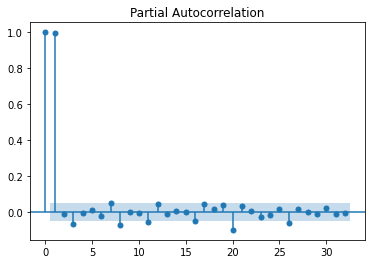

In [22]:
plot_pacf(data['close'])
plt.savefig('pacf.png')
plt.show()

Simple returns

In [23]:
data['simple_returns'] = data.close.pct_change()

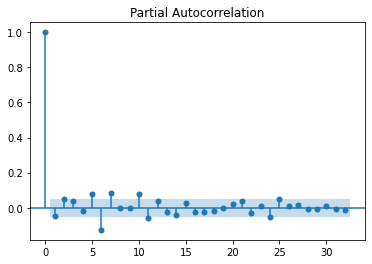

In [24]:
plot_pacf(data.close.pct_change().dropna())
plt.savefig('dacf.png')
plt.show()

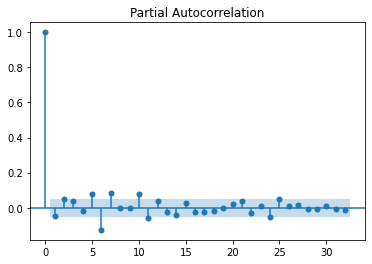

In [25]:
plot_pacf(data.close.pct_change().dropna())
plt.savefig('dacf.png')
plt.show()

Log-return data


In [26]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff() 

In [27]:
data['log_return'] = log_return(data.close)

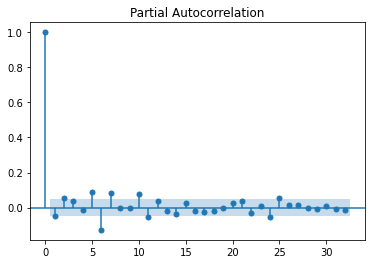

In [28]:
plot_pacf(data['log_return'].dropna())
plt.savefig('dacf.png')
plt.show()

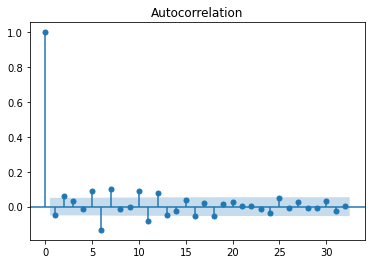

In [29]:
plot_acf(data['log_return'].dropna())
plt.savefig('dpacf.png')
plt.show()

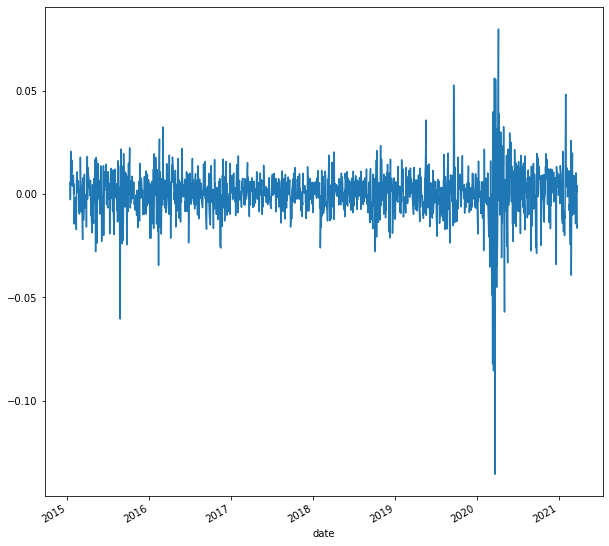

In [30]:
data.log_return.plot(figsize=(10,10))
plt.savefig('log.png')
plt.show()

In [31]:
data.describe()

,close,simple_returns,log_return
count,1530.000000,1529.000000,1529.000000
mean,10070.858595,0.000424,0.000359
std,1741.739834,0.011285,0.011372
min,6970.550000,-0.126676,-0.135449
25%,8547.312500,-0.004681,-0.004692
50%,10183.950000,0.000644,0.000643
75%,11239.287500,0.006191,0.006172
max,15335.800000,0.083002,0.079737


### Augmented Dickey-Fuller Unit root test
Price data

In [32]:
res_ADF = adfuller(data.close, regression='ct')
print(f'ADF Statistic: {res_ADF[0]}')
print(f'p-value: {res_ADF[1]}')
print(f'n_lags: {res_ADF[2]}')
print('Critial Values:')

for key, value in res_ADF[4].items():
    print(f'   {key}, {value}')  
    
print(f't_stat: {res_ADF[5]}')

ADF Statistic: -2.8408712833075223
p-value: 0.18233808345738017
n_lags: 12
Critial Values:
   1%, -3.964750156831415
   5%, -3.413388072649871
   10%, -3.1287561285882832
t_stat: 18459.56211599055


Can not reject null of unit root for price data.  Evidence for non-stationarity of log-returns.

### Log-returns

In [33]:
res_ADF = adfuller(data.log_return.dropna(), regression='c')
print(f'ADF Statistic: {res_ADF[0]}')
print(f'p-value: {res_ADF[1]}')
print(f'n_lags: {res_ADF[2]}')
print('Critial Values:')

for key, value in res_ADF[4].items():
    print(f'   {key}, {value}')  

print(f't_stat: {res_ADF[5]}')

ADF Statistic: -10.340668190824559
p-value: 2.6905223053837474e-18
n_lags: 11
Critial Values:
   1%, -3.434667995897907
   5%, -2.863447124874016
   10%, -2.5677853274099864
t_stat: -9237.660526023014


Reject null of unit root for log_return data. Evidence for stationarity of log-returns.

<a id='5min'></a>
# 5-minute intraday data

According to academic research on intraday trading we have to remove the overnight return, as our goal is to analyse high-frequency data in this section.

In [34]:
d = df.copy()
for i in range(len(d)-1):
    if (i+1)%75==0:
        d['close'][i] = np.nan
    else:
        pass
d['log_return'] = d.close.apply(np.log).diff()
d = d.dropna()
d.tail(3)

,close,log_return
date,,
2021-03-25 15:15:00,14299.75,0.000052
2021-03-25 15:20:00,14314.95,0.001062
2021-03-25 15:25:00,14346.40,0.002195


In [35]:
#def p(x):
#    return x[0]*x[2]
#(d['log_return']).rolling(window=3).apply(p, raw=True) 
#(d).rolling(window=2).agg(np.prod)

## Stationarity Analysis

### Price data

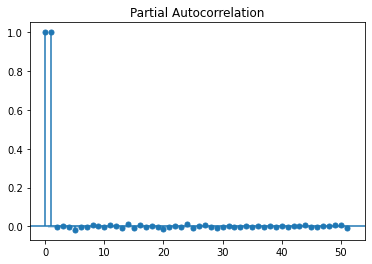

In [36]:
plot_pacf(d['close'])
plt.show()

### Log-return data

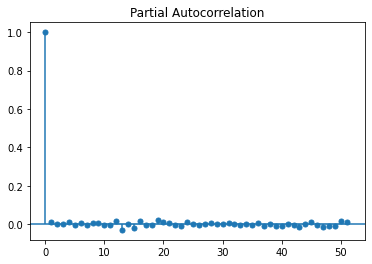

In [37]:
plot_pacf(d['log_return'])
plt.show()

### Augmented Dickey-Fuller Unit root test
Price data

In [38]:
res_ADF = adfuller(d.close, regression='ct')
print(f'ADF Statistic: {res_ADF[0]}')
print(f'p-value: {res_ADF[1]}')
print(f'n_lags: {res_ADF[2]}')
print('Critial Values:')

for key, value in res_ADF[4].items():
    print(f'   {key}, {value}')  
    
print(f't_stat: {res_ADF[5]}')

ADF Statistic: -2.1267193448189974
p-value: 0.5311056308221667
n_lags: 70
Critial Values:
   1%, -3.9588510535249517
   5%, -3.4105293074138894
   10%, -3.127073148860674
t_stat: 880341.4937230706


Can not reject null of unit root for HF price data.  Evidence for non-stationarity of log-returns.

In [39]:
res_ADF = adfuller(d.log_return, regression='c')
print(f'ADF Statistic: {res_ADF[0]}')
print(f'p-value: {res_ADF[1]}')
print(f'n_lags: {res_ADF[2]}')
print('Critial Values:')

for key, value in res_ADF[4].items():
    print(f'   {key}, {value}')  
    
print(f't_stat: {res_ADF[5]}')

ADF Statistic: -38.99581640720955
p-value: 0.0
n_lags: 69
Critial Values:
   1%, -3.4304085463377523
   5%, -2.8615658765939047
   10%, -2.5667837732002505
t_stat: -1174405.6137937787


Reject null of unit root for HF log_return data. Evidence for stationarity of log-returns.

## Financial returns modelling
ARCH https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_modeling.html

In [40]:
ar = ARX(d.log_return, lags=[19])
print(ar.fit().summary())

                     AR - Constant Variance Model Results                     
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:          Constant Variance   Log-Likelihood:                587240.
Distribution:                  Normal   AIC:                      -1.17447e+06
Method:            Maximum Likelihood   BIC:                      -1.17445e+06
                                        No. Observations:               111748
Date:                Thu, Aug 26 2021   Df Residuals:                   111746
Time:                        01:32:24   Df Model:                            2
                                    Mean Model                                   
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const          5.1746e-06  3.785e-06      1

In [41]:
ar.volatility = GARCH(p=1, o=1, q=1)
res = ar.fit(disp="off")
print(res.summary())

/opt/conda/lib/python3.7/site-packages/arch/univariate/base.py:755: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning,


                         AR - GJR-GARCH Model Results                         
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                  0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                615972.
Distribution:                  Normal   AIC:                      -1.23193e+06
Method:            Maximum Likelihood   BIC:                      -1.23187e+06
                                        No. Observations:               111748
Date:                Thu, Aug 26 2021   Df Residuals:                   111746
Time:                        01:32:25   Df Model:                            2
                                    Mean Model                                   
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const          5.1746e-06  8.946e-06      0

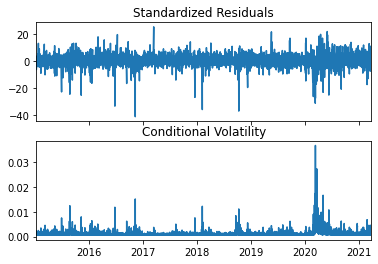

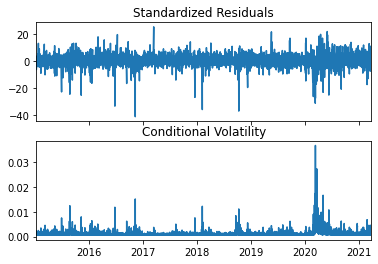

In [42]:
res.plot()